In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/covid-19_world.csv',sep=',')
df = df[ df["countriesAndTerritories"]=="France" ]
df.sort_values("dateRep")
for col_to_drop in ["day","month","year","countriesAndTerritories","geoId",
                    "countryterritoryCode","popData2018","continentExp"]:

    df=df.drop(col_to_drop,1)

df['dateRep'] = pd.to_datetime(df['dateRep'],format="%d/%m/%Y")
df = df.sort_values("dateRep")
df = df[ df["dateRep"] > "2020-01-24"]
df["cases"] = df["cases"].cumsum()
df["deaths"] = df["deaths"].cumsum()
df["susceptible"] = df.apply(lambda row : 500000 -(row["deaths"]+row["cases"]),axis=1)
df.head(5)

,dateRep,cases,deaths,susceptible
5624,2020-01-25,3,0,499997
5623,2020-01-26,3,0,499997
5622,2020-01-27,3,0,499997
5621,2020-01-28,3,0,499997
5620,2020-01-29,4,0,499996


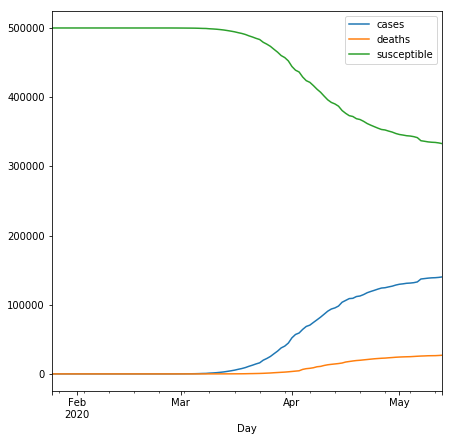

In [5]:
ax=df.plot(x="dateRep",y="cases",figsize=(7,7))
ax=df.plot(x="dateRep",y="deaths",ax=ax)
ax=df.plot(x="dateRep",y="susceptible",ax=ax)
plt.xlabel('Day')
plt.show()

In [61]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [80]:
# N = 66_987_244
N = 500_000
beta = 0.3  # infected person infects 1 other person per day
D = 10.0 # infections lasts ten days
gamma = 1.0 / D

S0, I0, R0 = N-1, 1, beta/gamma
t = np.arange(0,100) # Grid of time points (in days)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S_def, I_def, R_def = ret.T

In [81]:
def f(t, bt, gma):
    res = odeint(deriv, y0, t, args=(N,bt,gma))
    S,I,R = res.T
    return I

real = df["cases"].to_numpy()[:-10]
params, pcov = curve_fit(f, t, real)
print(params)

[2.32532352 2.17548262]


/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [82]:
new_beta, new_gamma = params
new_ret = odeint(deriv, y0, t, args=(N, new_beta, new_gamma))
S_fit, I_fit, R_fit = new_ret.T

In [83]:
def plotsir(t, S, I, R,df):
    f, ax = plt.subplots(1,1,figsize=(8,8))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t,df["cases"].to_numpy()[:-10],'k', alpha=0.7, lw=2, label='Really infected')
    ax.plot(t,df["susceptible"].to_numpy()[:-10], 'r', alpha=0.7, lw=2, label='Really Susceptible')
    ax.plot(t,df["deaths"].to_numpy()[:-10], 'c', alpha=0.7, lw=2, label='Really dead')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
    plt.show()

def plotfit(t, S, I, R,df):
    f, ax = plt.subplots(1,1)
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t,df["cases"].to_numpy()[:-10],'k', alpha=0.7, lw=2, label='Really infected')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
    plt.show()

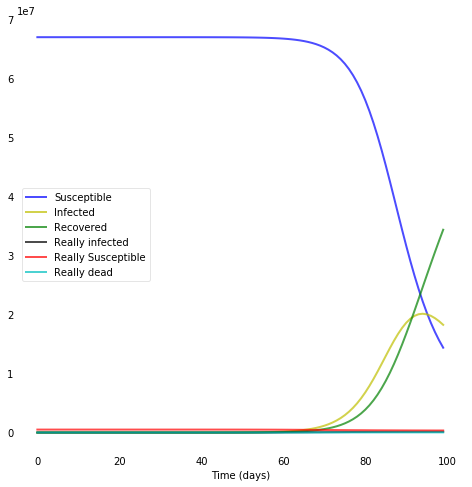

In [84]:
plotsir(t, S_def, I_def, R_def,df)

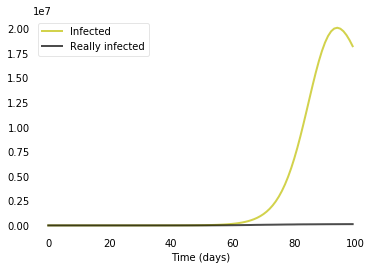

In [85]:
plotfit(t, S_def, I_def, R_def,df)

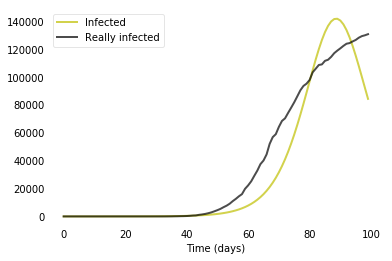

In [86]:
plotfit(t, S_fit, I_fit, R_fit,df)